## Deep Learning Applied to Images - Fine-tuning

#### Prof. Thomas da Silva Paula

### Fine-tuning example

* Using Keras
* Using MobileNet
* Using subset of the natural images dataset (https://www.kaggle.com/prasunroy/natural-images)

### Mount your drive and upload the dataset

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
! ls -lh /content/gdrive/My\ Drive/Datasets/natural_images_100

total 32K
drwx------ 2 root root 4.0K Oct 20 00:54 airplane
drwx------ 2 root root 4.0K Oct 20 00:54 car
drwx------ 2 root root 4.0K Oct 20 00:54 cat
drwx------ 2 root root 4.0K Oct 20 00:54 dog
drwx------ 2 root root 4.0K Oct 20 00:54 flower
drwx------ 2 root root 4.0K Oct 20 00:54 fruit
drwx------ 2 root root 4.0K Oct 20 00:54 motorbike
drwx------ 2 root root 4.0K Oct 20 00:54 person


### Imports

In [3]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import *

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input

from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical

### Exploring the dataset


In [4]:
def create_data_list(path):
    files = []
    labels = []
  
    for f in tqdm(os.listdir(path)):
        f_path = os.path.join(path, f)

        for i in os.listdir(f_path):
            i_path = os.path.join(f_path, i)
      
            files.append(i_path)
            labels.append(f)
      
    return files, labels

In [5]:
data_path = '/content/gdrive/My Drive/Datasets/natural_images_100'
files, labels = create_data_list(data_path)

100%|██████████| 8/8 [00:00<00:00, 502.33it/s]


In [6]:
print('Total images ', len(files), len(labels))

Total images  800 800


In [7]:
print(np.unique(labels))

['airplane' 'car' 'cat' 'dog' 'flower' 'fruit' 'motorbike' 'person']


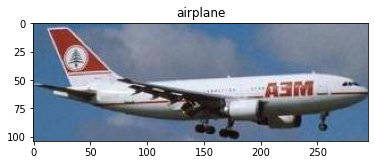

In [8]:
idx = 33
img_path = files[idx]
label = labels[idx]

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.title(label)
plt.imshow(img)

### Preparing the data

In [9]:
def preprocess_data(images, labels):
  
    X = []
    y = []

    for img_path, l in tqdm(zip(images, labels)):
        img = image.load_img(img_path, target_size=(224, 224))
        img = image.img_to_array(img)
        img = preprocess_input(img)

        X.append(img)
        y.append(l)

    return np.asarray(X), np.asarray(y)

In [10]:
X, y = preprocess_data(files, labels)

800it [03:33,  3.76it/s]


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [12]:
print('Train:', X_train.shape, y_train.shape)
print('Test:', X_test.shape, y_test.shape)

Train: (560, 224, 224, 3) (560,)
Test: (240, 224, 224, 3) (240,)


### Converting labels to integers


In [13]:
le = LabelEncoder()
le.fit(y_train)

LabelEncoder()

In [14]:
y_train = le.transform(y_train)
y_test = le.transform(y_test)

print('Train:', y_train.shape)
print('Test:', y_test.shape)

Train: (560,)
Test: (240,)


In [15]:
y_train[0]

1

### Converting integers to one-hot encoding

In [16]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print('Train:', y_train.shape)
print('Test:', y_test.shape)

Train: (560, 8)
Test: (240, 8)


In [17]:
y_train[0]

array([0., 1., 0., 0., 0., 0., 0., 0.], dtype=float32)

### Saving data to disk

In [18]:
dataset_path = '/content/gdrive/My Drive/Datasets/'

In [19]:
with open(os.path.join(dataset_path, 'X_train.npy'), 'wb') as f:
    np.save(f, X_train)

In [20]:
with open(os.path.join(dataset_path, 'X_test.npy'), 'wb') as f:
    np.save(f, X_test)

In [21]:
with open(os.path.join(dataset_path, 'y_train.npy'), 'wb') as f:
    np.save(f, y_train)

In [22]:
with open(os.path.join(dataset_path, 'y_test.npy'), 'wb') as f:
    np.save(f, y_test)

### Reading from disk

In [23]:
with open(os.path.join(dataset_path, 'X_train.npy'), 'rb') as f:
    X_train = np.load(f)
    
print(X_train.shape)

(560, 224, 224, 3)


In [25]:
with open(os.path.join(dataset_path, 'X_test.npy'), 'rb') as f:
    X_test = np.load(f)
    
print(X_test.shape)

(240, 224, 224, 3)


In [26]:
with open(os.path.join(dataset_path, 'y_train.npy'), 'rb') as f:
    y_train = np.load(f)
    
print(y_train.shape)

(560, 8)


In [27]:
with open(os.path.join(dataset_path, 'y_test.npy'), 'rb') as f:
    y_test = np.load(f)
    
print(y_test.shape)

(240, 8)


### Creating the model

In [28]:
alpha = 0.25
dropout = 1e-3
num_classes = 8
shape = (1, 1, int(1024 * alpha))

base_model = MobileNet(alpha=alpha, weights='imagenet', include_top=False, pooling='avg')
x = base_model.output
x = Reshape(shape, name='reshape_1')(x)
x = Dropout(dropout, name='dropout')(x)
x = Conv2D(num_classes, (1, 1),
                  padding='same',
                  name='conv_preds')(x)
x = Reshape((num_classes,), name='reshape_2')(x)
predictions = Activation('softmax', name='preds')(x)

new_model = Model(inputs=base_model.input, outputs=predictions)

2113536/2108140 [==============================] - 0s 0us/step


In [29]:
for layer in base_model.layers:
    layer.trainable = False

In [30]:
new_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [31]:
new_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, None, None, 3)     0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, None, 8)     216       
_________________________________________________________________
conv1_bn (BatchNormalization (None, None, None, 8)     32        
_________________________________________________________________
conv1_relu (ReLU)            (None, None, None, 8)     0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, None, None, 8)     72        
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, None, None, 8)    

### Training

In [32]:
history = new_model.fit(X_train, y_train,
                        validation_data=(X_test, y_test),
                        batch_size=32,
                        epochs=10)

Epoch 1/10
18/18 [==============================] - 1s 58ms/step - loss: 2.1489 - accuracy: 0.2750 - val_loss: 1.4133 - val_accuracy: 0.5208
Epoch 2/10
18/18 [==============================] - 0s 24ms/step - loss: 1.0753 - accuracy: 0.6625 - val_loss: 0.7512 - val_accuracy: 0.8125
Epoch 3/10
18/18 [==============================] - 0s 24ms/step - loss: 0.5940 - accuracy: 0.8571 - val_loss: 0.4634 - val_accuracy: 0.9042
Epoch 4/10
18/18 [==============================] - 0s 23ms/step - loss: 0.3886 - accuracy: 0.9179 - val_loss: 0.3391 - val_accuracy: 0.9208
Epoch 5/10
18/18 [==============================] - 0s 24ms/step - loss: 0.2852 - accuracy: 0.9464 - val_loss: 0.2647 - val_accuracy: 0.9375
Epoch 6/10
18/18 [==============================] - 0s 23ms/step - loss: 0.2252 - accuracy: 0.9500 - val_loss: 0.2203 - val_accuracy: 0.9583
Epoch 7/10
18/18 [==============================] - 0s 23ms/step - loss: 0.1824 - accuracy: 0.9625 - val_loss: 0.1834 - val_accuracy: 0.9667
Epoch 8/10
18

In [33]:
new_model.save_weights('fine_tuning.h5')

### Downloading our model

In [34]:
from google.colab import files

files.download('fine_tuning.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Evaluating our model

In [35]:
y_test_pred = new_model.predict(X_test, batch_size=32)

In [36]:
print('Before', y_test.shape, y_test_pred.shape)
print('Example', y_test[0])
print('')

y_test_int = np.argmax(y_test, axis=1)
y_test_pred_int = np.argmax(y_test_pred, axis=1)

print('After', y_test_int.shape, y_test_pred_int.shape)
print('Example', y_test_int[0])

Before (240, 8) (240, 8)
Example [0. 0. 0. 0. 1. 0. 0. 0.]

After (240,) (240,)
Example 4


In [37]:
print(classification_report(y_test_int, y_test_pred_int))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        35
           1       1.00      1.00      1.00        21
           2       0.97      1.00      0.99        34
           3       0.93      0.93      0.93        30
           4       1.00      0.97      0.98        32
           5       1.00      1.00      1.00        29
           6       1.00      0.97      0.98        32
           7       0.96      1.00      0.98        27

    accuracy                           0.98       240
   macro avg       0.98      0.98      0.98       240
weighted avg       0.98      0.98      0.98       240



In [38]:
classes = np.unique(labels)
print(classes)

['airplane' 'car' 'cat' 'dog' 'flower' 'fruit' 'motorbike' 'person']


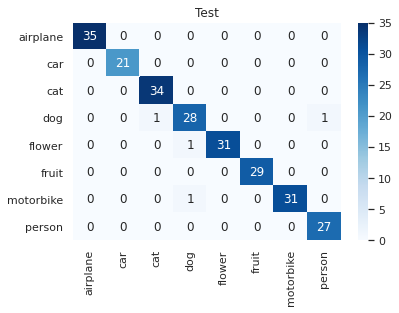

In [39]:
cm = confusion_matrix(y_test_int, y_test_pred_int)
sns.set()
plt.figure()
plt.title('Test')
sns.heatmap(cm, annot=True, yticklabels=classes, xticklabels=classes, cmap='Blues', fmt='d')

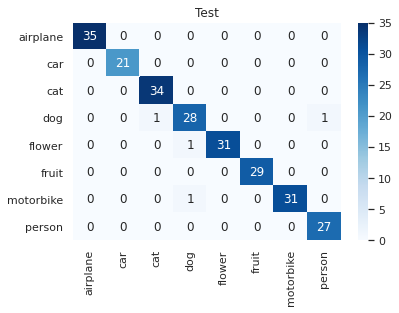

In [40]:
cm = confusion_matrix(y_test_int, y_test_pred_int)
sns.set()
plt.figure()
plt.title('Test')
sns.heatmap(cm, annot=True, yticklabels=classes, xticklabels=classes, cmap='Blues', fmt='d')

### Testing predictions

In [41]:
! wget https://upload.wikimedia.org/wikipedia/commons/thumb/2/20/PR-MBH_Airbus_A320_TAM_%287319491954%29.jpg/1280px-PR-MBH_Airbus_A320_TAM_%287319491954%29.jpg

--2020-11-24 00:43:45--  https://upload.wikimedia.org/wikipedia/commons/thumb/2/20/PR-MBH_Airbus_A320_TAM_%287319491954%29.jpg/1280px-PR-MBH_Airbus_A320_TAM_%287319491954%29.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.154.240, 2620:0:861:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.154.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 192476 (188K) [image/jpeg]
Saving to: ‘1280px-PR-MBH_Airbus_A320_TAM_(7319491954).jpg’

1280px-PR-MBH_Airbu 100%[===================>] 187.96K  --.-KB/s    in 0.007s  

2020-11-24 00:43:45 (28.1 MB/s) - ‘1280px-PR-MBH_Airbus_A320_TAM_(7319491954).jpg’ saved [192476/192476]



In [42]:
!ls -lh

total 1.3M
-rw-r--r-- 1 root root 188K Jul 25  2019 '1280px-PR-MBH_Airbus_A320_TAM_(7319491954).jpg'
-rw-r--r-- 1 root root 1.1M Nov 24 00:43  fine_tuning.h5
drwx------ 5 root root 4.0K Nov 24 00:37  gdrive
drwxr-xr-x 1 root root 4.0K Nov 13 17:33  sample_data


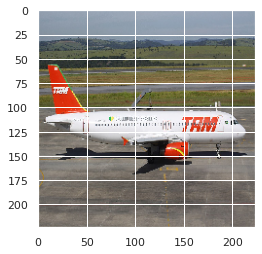

In [43]:
img_path = '1280px-PR-MBH_Airbus_A320_TAM_(7319491954).jpg'
img = image.load_img(img_path, target_size=(224, 224))
plt.imshow(img)

In [44]:
img = image.img_to_array(img)
img = preprocess_input(img)

print(img.shape)

(224, 224, 3)


In [45]:
preds = new_model.predict(np.expand_dims(img, axis=0))
print(preds)

[[9.6954054e-01 1.0675243e-02 5.8782278e-03 5.5402587e-03 6.8423566e-03
  6.2716822e-04 2.7410735e-04 6.2213262e-04]]


<BarContainer object of 8 artists>

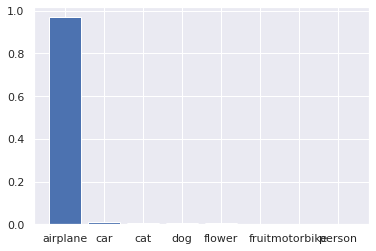

In [46]:
plt.bar(np.arange(0, len(preds[0])), preds[0], tick_label=classes)